# N starvation 

## Which N sources allow MED4 to grow

check out Escher visualization https://escher.readthedocs.io/en/latest/getting_started.html

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import numpy as np
import seaborn as sns
import itertools
from matplotlib.colors import LogNorm, Normalize


In [159]:
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import production_envelope


In [160]:
sns.hls_palette

<function seaborn.palettes.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)>

In [161]:
# values from Ofaim at el.

PARAMETER_VALUES = [#"Name",     "Reaction ID",          "Lower bound", "UpperBound"
                   ["HCO3",      "HCO3EXcar",            -8,            0],
                   #["Nitrogen",  "AmmoniaEX",            -0.56,         0],
                   #["Phosphate", "FAKEOrthophosphateEX", -0.1,          0],
                   ["Light",     "LightEX",              -150,          0]]
CO2MAX = 0.82

# Block fake reactions
FAKE_TRANSPORT = ["AminosugarsOUT", "FAKEAAOUT", "FAKEABPOUT", "FAKEacpTRANS", "FAKEApoacpTRANS", "FAKEThioredoxinTRANS", "FreefattyacidsOUT", "7NMeth7carbOUT", "ArtificialproteinOUT", "FADOUT", "LipoylproteinTRANS", "MenaquinoneOUT", "NicotinateOUT", "THFpolyglutOUT", "Thiamin_dpOUT"]


In [268]:
def get_elements(rid):
    r = model.reactions.get_by_id(rid)
    m = r.reactants[0]    
    elements = m.elements.copy()
    
    res = {
        'reaction' : rid,
        'metabolite' : m.name,
        'N' : 'N' in elements,
        'C' : 'C' in elements,
        
    }
    return res

# Import model and manipulate based on Ofaim at el

In [163]:
import os
model_dpath = os.path.join('..', 'Model_files')
model_fname = 'iSO595v7.xml'
model_fpath = os.path.join(model_dpath, model_fname)


In [164]:
model = cobra.io.read_sbml_model(model_fpath)

In [165]:
# manipulations copied from Ofaim at el.

remove_blocked = False

# Block H2S
model.reactions.H2SEX.lower_bound = 0

# Block fake transports
for rid in FAKE_TRANSPORT:
    model.reactions.get_by_id(rid).bounds = (0,0)

# Remove blocked reactions
if remove_blocked:
    blocked = cobra.flux_analysis.find_blocked_reactions(model, open_exchanges = True)
    print('blocked', len(blocked), blocked)
    model.remove_reactions([model.reactions.get_by_id(r_id) for r_id in blocked])

# Block maximum CO2 production
model.reactions.CO2EX.bounds = (0, CO2MAX)

for i, row in enumerate(PARAMETER_VALUES):
    # Row: Name, Reaction ID, lower bound, upper bound
    key = row[0]
    reaction_id = row[1]
    lower_bound = row[2]
    upper_bound = row[3]
    r = model.reactions.get_by_id(reaction_id)
    # Fix flux
    r.bounds = (lower_bound, upper_bound)

In [166]:
exchange_ids = [r.id for r in model.exchanges] # + ["R00024"]

In [167]:
print('reactions', len(model.reactions))
print('metabolites', len(model.metabolites))
print('genes', len(model.genes))

reactions 994
metabolites 802
genes 595


In [168]:
model

Name,COBRAModel
Memory address,0x07f97c442f730
Number of metabolites,802
Number of reactions,994
Number of groups,55
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"Cytoplasm, Extracellular, unknownCompartment2, Periplasm, unknownCompartment5"


In [169]:
model.metabolites.get_by_id('Carbamate[c]')

Metabolite identifier,Carbamate[c]
Name,Carbamate
Memory address,0x7f97c4440c40
Formula,CH3NO2
Compartment,c
In 4 reaction(s),"R03546, R10949, R07316, R01395"


In [170]:
cobra.Configuration()

Attribute,Description,Value
solver,Mathematical optimization solver,glpk
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,11
cache_directory,Path for the model cache,/home/oweissberg/.cache/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


In [171]:
model.reactions.get_by_id('PyruvateEX')

Reaction identifier,PyruvateEX
Name,PyruvateEX
Memory address,0x7f97c3d30490
Stoichiometry,Pyruvate[e] --> Pyruvate[e] -->
GPR,
Lower bound,0.0
Upper bound,1000.0


In [172]:
model.reactions.get_by_id('AmmoniaEX')

Reaction identifier,AmmoniaEX
Name,Ammonia Exchange
Memory address,0x7f97c3d855b0
Stoichiometry,Ammonia[e] <=> Ammonia <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [173]:
model.reactions.get_by_id('LightEX')

Reaction identifier,LightEX
Name,Light Exchange
Memory address,0x7f97c3d85310
Stoichiometry,Photon[e] <-- Photon <--
GPR,
Lower bound,-150
Upper bound,0


In [174]:
model.reactions.get_by_id('BIOMASS')

Reaction identifier,BIOMASS
Name,Biomass formation
Memory address,0x7f97c4127c70
Stoichiometry,104.0 ATP[c] + 0.0324116276714271 BioPool[c] + 0.0268408791654006 Bmineral[c] + 0.0559910868023904 Cell_wall[c] + 0.00111921401802897 Free_nucleic_acids[c] + 104.0 H2O[c] + 0.649245416793275... 104.0 ATP + 0.0324116276714271 BioPool + 0.0268408791654006 Trace metals and minerals + 0.0559910868023904 Cell wall Biomass precursor + 0.00111921401802897 Free nucleic acids + 104.0 H2O +...
GPR,
Lower bound,0.0
Upper bound,1000.0


# Identify N sources where MED4 grows on

In [198]:
model.medium

{'AmmoniaEX': 1000.0,
 'CadmiumEX': 1000.0,
 'CalciumEX': 1000.0,
 'ChlorideEX': 1000.0,
 'CobaltEX': 1000.0,
 'CopperEX': 1000.0,
 'FAKEOrthophosphateEX': 1000.0,
 'H2OEX': 1000.0,
 'HCO3EXcar': 8,
 'HEX': 1000.0,
 'IronEX': 1000.0,
 'LightEX': 150,
 'MagnesiumEX': 1000.0,
 'MolybdenumEX': 1000.0,
 'O2EX': 1000.0,
 'PotassiumEX': 1000.0,
 'SelenateEX': 1000.0,
 'SodiumEX': 1000.0,
 'StrontiumEX': 1000.0,
 'SulfateEX': 1000.0,
 'ZincEX': 1000.0,
 'H2O2EX': 1000.0}

In [177]:
# try to each exchange one by one
results = list()

def _check_medium(met1, met2=None):
    with model:
        medium = model.medium
        medium["AmmoniaEX"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        solution = model.optimize()
        return {'uptake' : met1, 'objective_value' : solution.objective_value}
results = [_check_medium(met) for met in exchange_ids]        

In [178]:
df = pd.DataFrame(results)

In [179]:
df_growing = df.loc[(df.objective_value > 1e-5), 
                    ['uptake','objective_value']
                   ].nlargest(n=1000, columns='objective_value').reset_index(drop=True)

In [277]:
tdf = pd.DataFrame.from_records(df_growing.uptake.apply(get_elements))
df_growing = pd.merge(df_growing, tdf, left_on='uptake', right_on='reaction')

### N sources that MED4 can grow on 

In [279]:
df_growing

,uptake,objective_value,reaction,metabolite,N,C
0,GuanosineEX,1.239447,GuanosineEX,Guanosine[e],False,False
1,L_AspartateEX,0.238582,L_AspartateEX,L-Aspartate,True,True
2,GlutathioneEX,0.137239,GlutathioneEX,Glutathione[e],False,False
3,L_GlutamineEX,0.121923,L_GlutamineEX,L-Glutamine,True,True
4,L_SerineEX,0.118972,L_SerineEX,L-Serine,True,True
5,L_CystineEX,0.116452,L_CystineEX,L-Cystine,True,True
6,L_AlanineEX,0.116452,L_AlanineEX,L-Alanine,True,True
7,L_LeucineEX,0.103996,L_LeucineEX,L-Leucine,True,True
8,GlycineEX,0.101626,GlycineEX,Glycine,True,True
9,UreaEX,0.098462,UreaEX,Urea,True,True


### Even when all other potential mediums are available, MED4 does not grow

In [182]:
# open all additional mediums (all those that do not facilitate growth by themselves)
not_open_boundary_ids = [i for i in boundary_ids if (i not in model.medium) and (i not in df_growing.uptake.values)]
with model:
    medium = model.medium
    medium["AmmoniaEX"] = 0.0
    for i in not_open_boundary_ids:
        medium[i] = 1000.0
    model.medium = medium
    solution = model.optimize()
    print(model.summary())


Objective
1.0 BIOMASS = 1.2838897935641987e-15

Uptake
------
 Metabolite   Reaction   Flux  C-Number  C-Flux
 Ethanol[e]  EthanolEX 0.1579         0   0.00%
Fumarate[e] FumarateEX 0.1579         0   0.00%
Glycogen[e] GlycogenEX 0.1579         6 100.00%
  Oxygen[e]       O2EX 0.8686         0   0.00%

Secretion
---------
Metabolite  Reaction    Flux  C-Number  C-Flux
    CO2[e]     CO2EX -0.3159         1 100.00%
Citrate[e] CitrateEX -0.1579         0   0.00%
Formate[e] FormateEX -0.6317         0   0.00%
    H2O[e]     H2OEX -0.3159         0   0.00%



### Force MED4 to uptake the potential N sources, limit growth (biomass), and see what is secreted

In [258]:
def _force_feeding(met1):
    with model:
        medium = model.medium
        medium["AmmoniaEX"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        model.reactions.get_by_id(met1).upper_bound = -1e-5
        model.reactions.BIOMASS.upper_bound = 1e-2
        solution = model.optimize()
        print(met1, model.summary())
        fluxes = flux_variability_analysis(model, model.boundary, loopless=True, fraction_of_optimum=0.9, processes=11)
        fluxes['uptake'] = met1
        return fluxes
fluxes_df_list = [_force_feeding(met1) for met1 in df_growing['uptake']]

GuanosineEX Objective
1.0 BIOMASS = 0.01

Uptake
------
         Metabolite             Reaction      Flux  C-Number  C-Flux
         Cadmium[e]            CadmiumEX 4.827E-07         0   0.00%
  Calcium_cation[e]            CalciumEX 0.0002676         0   0.00%
    Chloride_ion[e]           ChlorideEX  0.002379         0   0.00%
      Cobalt_ion[e]             CobaltEX 1.552E-05         0   0.00%
          Copper[e]             CopperEX 8.734E-07         0   0.00%
  Orthophosphate[e] FAKEOrthophosphateEX  0.003633         0   0.00%
       Guanosine[e]          GuanosineEX    0.4954         0   0.00%
            HCO3[e]            HCO3EXcar   0.06454         1 100.00%
             Fe2[e]               IronEX 3.232E-05         0   0.00%
          Photon[e]              LightEX  0.001817         0   0.00%
Magnesium_cation[e]          MagnesiumEX  0.001589         0   0.00%
          Oxygen[e]                 O2EX     1.032         0   0.00%
               K[e]          PotassiumEX 0.0009

L_GlutamineEX Objective
1.0 BIOMASS = 0.01

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.827E-07         0  0.00%
  Calcium_cation[e]            CalciumEX 0.0002676         0  0.00%
    Chloride_ion[e]           ChlorideEX  0.002379         0  0.00%
      Cobalt_ion[e]             CobaltEX 1.552E-05         0  0.00%
          Copper[e]             CopperEX 8.734E-07         0  0.00%
  Orthophosphate[e] FAKEOrthophosphateEX  0.003633         0  0.00%
            HCO3[e]            HCO3EXcar    0.4507         1 58.16%
             Fe2[e]               IronEX 3.232E-05         0  0.00%
     L_Glutamine[e]        L_GlutamineEX   0.06483         5 41.84%
          Photon[e]              LightEX     11.52         0  0.00%
Magnesium_cation[e]          MagnesiumEX  0.001589         0  0.00%
               K[e]          PotassiumEX 0.0009516         0  0.00%
        Selenate[e]           SelenateEX 0.0007635        

L_AlanineEX Objective
1.0 BIOMASS = 0.01

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.827E-07         0  0.00%
  Calcium_cation[e]            CalciumEX 0.0002676         0  0.00%
    Chloride_ion[e]           ChlorideEX  0.002379         0  0.00%
      Cobalt_ion[e]             CobaltEX 1.552E-05         0  0.00%
          Copper[e]             CopperEX 8.734E-07         0  0.00%
  Orthophosphate[e] FAKEOrthophosphateEX  0.003633         0  0.00%
            HCO3[e]            HCO3EXcar    0.2865         1 15.55%
             Fe2[e]               IronEX 3.232E-05         0  0.00%
       L_Alanine[e]          L_AlanineEX    0.5186         3 84.45%
          Photon[e]              LightEX     8.296         0  0.00%
Magnesium_cation[e]          MagnesiumEX  0.001589         0  0.00%
               K[e]          PotassiumEX 0.0009516         0  0.00%
        Selenate[e]           SelenateEX 0.0007635         0

UreaEX Objective
1.0 BIOMASS = 0.01

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.827E-07         0  0.00%
  Calcium_cation[e]            CalciumEX 0.0002676         0  0.00%
    Chloride_ion[e]           ChlorideEX  0.002379         0  0.00%
      Cobalt_ion[e]             CobaltEX 1.552E-05         0  0.00%
          Copper[e]             CopperEX 8.734E-07         0  0.00%
  Orthophosphate[e] FAKEOrthophosphateEX  0.003633         0  0.00%
            HCO3[e]            HCO3EXcar    0.5425         1 92.59%
             Fe2[e]               IronEX 3.232E-05         0  0.00%
          Photon[e]              LightEX     12.39         0  0.00%
Magnesium_cation[e]          MagnesiumEX  0.001589         0  0.00%
               K[e]          PotassiumEX 0.0009516         0  0.00%
        Selenate[e]           SelenateEX 0.0007635         0  0.00%
   Sodium_cation[e]             SodiumEX  0.004461         0  0.0

CyanateEX Objective
1.0 BIOMASS = 0.01

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.827E-07         0  0.00%
  Calcium_cation[e]            CalciumEX 0.0002676         0  0.00%
    Chloride_ion[e]           ChlorideEX  0.002379         0  0.00%
      Cobalt_ion[e]             CobaltEX 1.552E-05         0  0.00%
          Copper[e]             CopperEX 8.734E-07         0  0.00%
         Cyanate[e]            CyanateEX   0.08685         1 13.80%
  Orthophosphate[e] FAKEOrthophosphateEX  0.003633         0  0.00%
            HCO3[e]            HCO3EXcar    0.5425         1 86.20%
             Fe2[e]               IronEX 3.232E-05         0  0.00%
          Photon[e]              LightEX     12.39         0  0.00%
Magnesium_cation[e]          MagnesiumEX  0.001589         0  0.00%
               K[e]          PotassiumEX 0.0009516         0  0.00%
        Selenate[e]           SelenateEX 0.0007635         0  

In [259]:
force_feeding_df = pd.concat(fluxes_df_list)

In [260]:
force_feeding_df.index = force_feeding_df.index.set_names(['secretion'])
force_feeding_df = force_feeding_df.reset_index()
force_feeding_df.head()

,secretion,minimum,maximum,uptake
0,AminosugarsEX,0.0,0.0,GuanosineEX
1,FAKEAAEX,0.0,0.0,GuanosineEX
2,FAKEABPEX,0.0,0.0,GuanosineEX
3,FAKEacpEX,0.0,0.0,GuanosineEX
4,FAKEApoacpEX,0.0,0.0,GuanosineEX


In [274]:
force_feeding_df.loc[force_feeding_df.maximum > 1e-3].groupby('secretion').minimum.count()

secretion
4_AminobenzoateEX                      16
4_Methyl_2_oxopentanoateEX             16
5_MethylthioadenosineEX                16
AcetateEX                              16
AdenineEX                              16
AmmoniaEX                              15
B12EX                                  16
BiomassEX                              16
BiotinEX                               16
CO2EX                                  16
CadaverineEX                           16
CitrateEX                              16
DethiobiotinEX                         16
EthanolEX                              16
FormateEX                              16
FumarateEX                             16
GlutathioneEX                          15
GlycineEX                              15
GlycogenEX                             16
GlycolateEX                            16
GuanineEX                              15
GuanosineEX                            15
H2O2EX                                 16
H2OEX                   

In [263]:
drop_columns = ["tRNAEX", 'CadaverineEX', 'CadmiumEX','CalciumEX', 'ChlorideEX', 'CalciumEX', 'ChlorideEX',
                'IronEX','MagnesiumEX', 'PotassiumEX', 'SelenateEX', 'SodiumEX', 'StrontiumEX', 'ZincEX', 'R00024',
                'H2OEX', "HEX", 'BiomassEX', 'CO2EX', 'O2EX']

force_feeding_df.loc[(force_feeding_df.maximum > 1e-3) & 
                     (~force_feeding_df.uptake.isin(drop_columns)),'secretion'].unique()

array(['B12EX', 'BiotinEX', 'MethanolEX',
       'SAdenosyl4methylthio2oxobutanoateEX', 'SMethyl5thioDriboseEX',
       'tRNAEX', 'GlycolateEX', 'AmmoniaEX', 'BiomassEX', 'CadaverineEX',
       'CO2EX', 'GlycogenEX', 'H2OEX', 'H2SEX', 'HEX', 'O2EX',
       'SpermineEX', 'ThiosulfateEX', 'UreaEX', 'L_AlanineEX',
       'L_ArginineEX', 'L_AsparagineEX', 'L_AspartateEX', 'L_CystineEX',
       'L_GlutamateEX', 'L_GlutamineEX', 'GlycineEX', 'L_HistidineEX',
       'L_IsoleucineEX', 'L_LeucineEX', 'L_LysineEX', 'L_MethionineEX',
       'L_PhenylalanineEX', 'L_ProlineEX', 'L_SerineEX', 'L_ThreonineEX',
       'L_TryptophanEX', 'L_TyrosineEX', 'L_ValineEX', 'PhospholipidEX',
       'LPSEX', 'AcetateEX', 'CitrateEX', 'FormateEX', 'PyruvateEX',
       'FumarateEX', 'GlutathioneEX', '4_Methyl_2_oxopentanoateEX',
       'PantothenateEX', 'SuccinateEX', 'ThymidineEX', 'XanthosineEX',
       '4_AminobenzoateEX', '5_MethylthioadenosineEX', 'AdenineEX',
       'DethiobiotinEX', 'GuanineEX', 'Putrescin

In [269]:
drop_columns = ["tRNAEX", 'CadaverineEX', 'CadmiumEX','CalciumEX', 'ChlorideEX', 'CalciumEX', 'ChlorideEX',
                'IronEX','MagnesiumEX', 'PotassiumEX', 'SelenateEX', 'SodiumEX', 'StrontiumEX', 'ZincEX', 'R00024',
                'H2OEX', "HEX", 'BiomassEX', 'CO2EX', 'O2EX']
pdf = force_feeding_df.loc[(force_feeding_df.maximum > 1e-3) & (~force_feeding_df.secretion.isin(drop_columns))
                          ].pivot_table(columns='uptake', index='secretion', values='maximum', fill_value=0)

In [270]:
col_anno = pd.DataFrame.from_records([get_elements(i) for i in pdf.columns])
row_anno = pd.DataFrame.from_records([get_elements(i) for i in pdf.index])
N_lut = {True: '#BF9270', False : '#FFEDDB'}
C_lut = {True: '#94B49F', False : '#FCF8E8'}
row_anno.N = row_anno.N.map(N_lut)
row_anno.C = row_anno.C.map(C_lut)
col_anno.N = col_anno.N.map(N_lut)
col_anno.C = col_anno.C.map(C_lut)
row_anno.index = row_anno.reaction
col_anno.index = col_anno.reaction

Text(0.5, 1, "Maximum FVA Flux - secretion when 'force fed'")

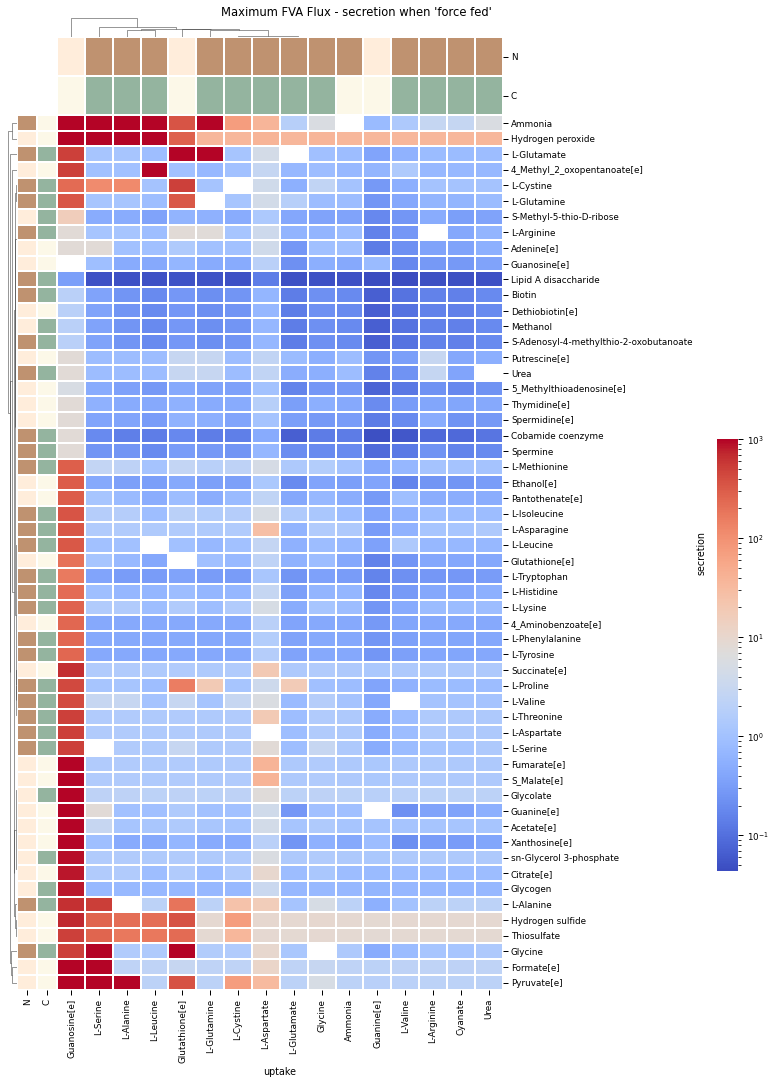

In [271]:

sns.clustermap(pdf, norm=LogNorm(), 
               cmap='coolwarm', figsize=(10,15), 
               linewidths=0.1, #cbar_kws= dict(location='right'),
               row_colors=row_anno[['N', 'C']],
               col_colors=col_anno[['N', 'C']],
               yticklabels= row_anno.metabolite,
               xticklabels= col_anno.metabolite,
               colors_ratio=0.04,
              robust=True, cbar_pos=(1, .2, .03, .4),
              dendrogram_ratio=0.02)
plt.suptitle("Maximum FVA Flux - secretion when 'force fed'", y=1)

In [272]:
len(exchange_ids)

101

In [281]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

In [ ]:
double_gene_deletion()